# model load

In [1]:
from model.crossmodal.main import Model, VQModel
from model.crossmodal.old.params import params as vaeparams
from model.crossmodal.vq.params import params as vqparams
from data.dataset import ImageDataset
import torch
import torchaudio
import nnmnkwii.datasets.jvs
from nnmnkwii.io import hts
import pyworld as pw
import pysptk as ps
import numpy as np
from matplotlib import pyplot as plt
import librosa
from nnmnkwii.metrics import melcd

import os

import IPython.display

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
vae = Model(vaeparams)
vqvae = VQModel(vqparams)

In [3]:
import glob
pvae = glob.glob("crosslogs/lightning_logs/version_40/checkpoints/*.ckpt")[0]
pvq = glob.glob("crosslogs/lightning_logs/version_39/checkpoints/*.ckpt")[0]

In [4]:
vae = vae.load_from_checkpoint(pvae)
vqvae = vqvae.load_from_checkpoint(pvq)
vae.eval()
vqvae.eval()

VQModel(
  (ue): UttrEncoder(
    (model): ModuleDict(
      (lr): GLU()
      (conv1a): Conv2d(1, 16, kernel_size=(3, 9), stride=(1, 1), padding=(1, 4), bias=False, padding_mode=replicate)
      (bn1a): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1b): Conv2d(1, 16, kernel_size=(3, 9), stride=(1, 1), padding=(1, 4), bias=False, padding_mode=replicate)
      (bn1b): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2a): Conv2d(16, 32, kernel_size=(4, 8), stride=(2, 2), padding=(1, 3), bias=False, padding_mode=replicate)
      (bn2a): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2b): Conv2d(16, 32, kernel_size=(4, 8), stride=(2, 2), padding=(1, 3), bias=False, padding_mode=replicate)
      (bn2b): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3a): Conv2d(32, 32, kernel_size=(4, 8), stride=(2, 2), padding=(1, 3),

In [5]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()
    print(waveform.shape)
    num_channels, num_frames = waveform.shape
    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.xlabel('Time[sec]')
    plt.ylabel('Frequency[Hz]')
    plt.show(block=False)

In [6]:
def ex_mc(x):
    f0, sp, ap = pw.wav2world(x.squeeze(0).to(torch.double).numpy(), 24000)
    mc = ps.sp2mc(sp, order=35, alpha=ps.util.mcepalpha(24000))
    mc = torch.from_numpy(mc.T)
    return mc, f0, sp, ap

In [7]:
def synth(mc, f0, ap):
    f0 = f0[:mc.shape[1]]
    ap = ap[:mc.shape[1]]
    mc = mc.T.numpy()
    sp = ps.mc2sp(mc, alpha=ps.util.mcepalpha(24000), fftlen=1024)
    sp = sp.astype(np.double)[:len(f0)]
    return pw.synthesize(f0, sp, ap, 24000)

In [8]:
def calc_melcd(a_mcs, b_mcs):
    """
    input list(np.ndarray)
    """
    m = []
    for a, b in zip(a_mcs, b_mcs):
        min_cost, wp = librosa.sequence.dtw(a[1:, :], b[1:, :])
        m.append(melcd(a[:, wp[:,0]].T, b[:, wp[:,1]].T , lengths=None))
    return np.mean(m), np.std(m)

In [9]:
root = os.path.join("../",  'jvs_r9y9_ver1')
wav_paths = nnmnkwii.datasets.jvs.WavFileDataSource(root, categories=["parallel"])
idatasets = ImageDataset(root="data/images")

In [10]:
x1 = torchaudio.load(wav_paths.collect_files()[899])[0]
y1 = idatasets[4]

x2 = torchaudio.load(wav_paths.collect_files()[1299])[0]
y2 = idatasets[5]

/work/kenya/splitternet/data/dataset.py:173: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.random.choice(self.data[label][index])
/work/kenya/splitternet/data/dataset.py:173: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.random.choice(self.data[label][index])


In [11]:
x1_mc, x1_f0, x1_sp, x1_ap = ex_mc(x1)
x2_mc, x2_f0, x2_sp, x2_ap = ex_mc(x2)

再構成音声
crossmodalVC
VQ-crossmodalVC

In [12]:
xx = synth(x2_mc, x2_f0, x2_ap)

/tmp/ipykernel_914552/948336759.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  plot_specgram(torch.tensor([xx]), sample_rate=24000, title="reconstructed")


(1, 224520)


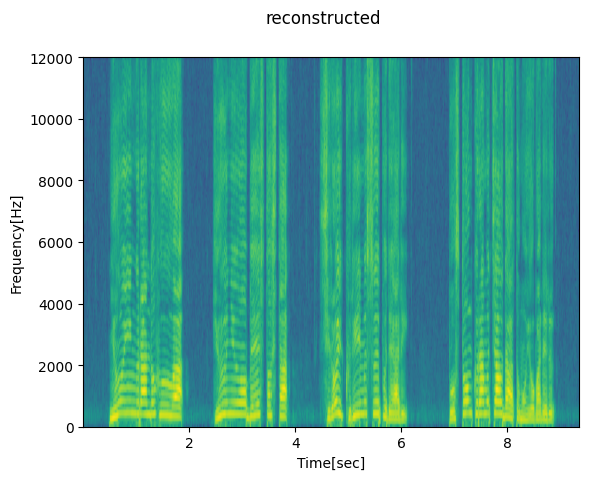

In [13]:
plot_specgram(torch.tensor([xx]), sample_rate=24000, title="reconstructed")

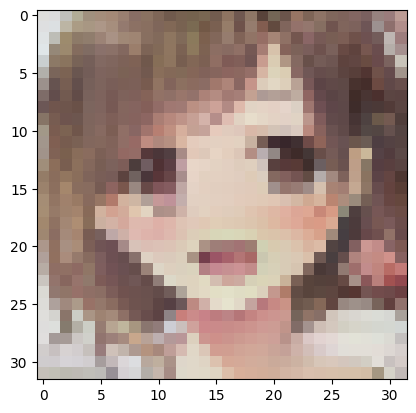

In [14]:
plt.imshow(y2.to(torch.uint8).permute(1, 2, 0))

In [15]:
x_hat2_mc = vae(x1_mc.unsqueeze(0).unsqueeze(0).to(torch.float), y2.unsqueeze(0)).squeeze(0).squeeze(0)
x_hat2_mc = x_hat2_mc.detach()
xx_hat = synth(x_hat2_mc, x2_f0, x2_ap)

(1, 220800)


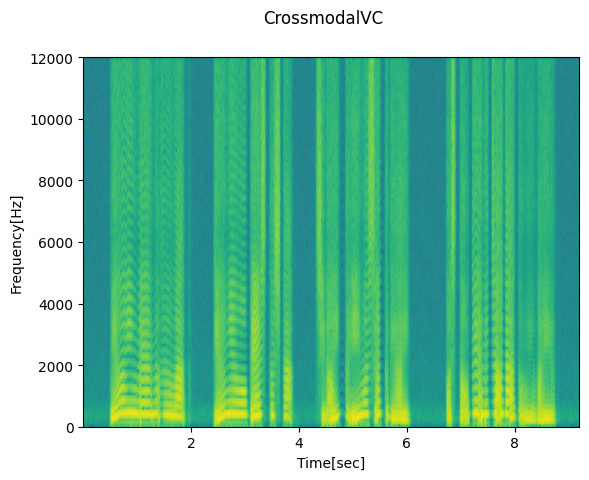

In [16]:
plot_specgram(torch.tensor([xx_hat]), sample_rate=24000, title="CrossmodalVC")

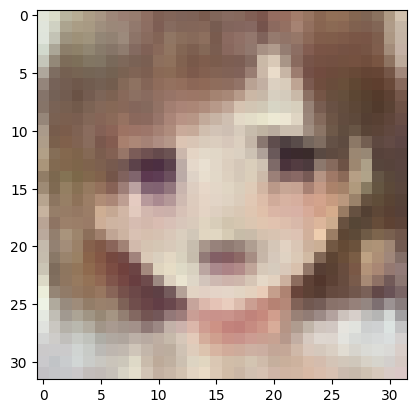

In [17]:
yy2_hat = vae.rc_image(y2.unsqueeze(0))
plt.imshow(yy2_hat.permute(1, 2, 0))

In [18]:
x_bar2_mc = vqvae(x1_mc.unsqueeze(0).unsqueeze(0).to(torch.float), y2.unsqueeze(0)).squeeze(0).squeeze(0)
x_bar2_mc = x_bar2_mc.detach()
xx_bar = synth(x_bar2_mc, x2_f0, x2_ap)

(1, 220800)


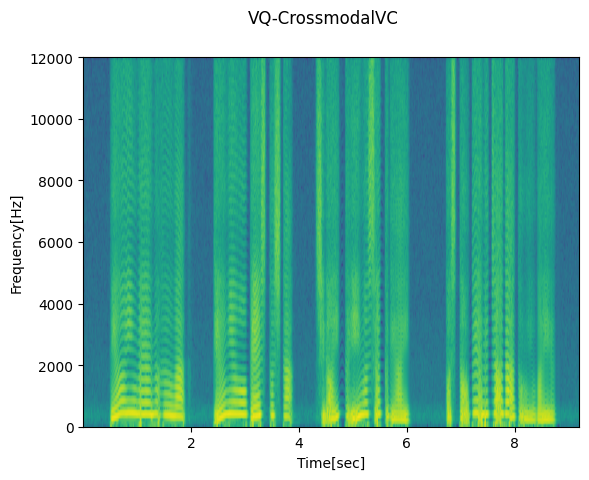

In [19]:
plot_specgram(torch.tensor([xx_bar]), sample_rate=24000, title="VQ-CrossmodalVC")

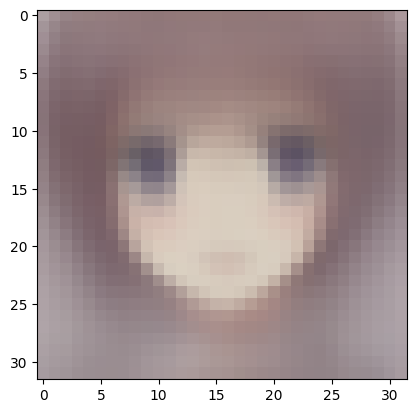

In [20]:
yy2_bar = vqvae.rc_image(y2.unsqueeze(0))
plt.imshow(yy2_bar.permute(1, 2, 0))

# mel

In [21]:
y1 = idatasets[4]
y2 = idatasets[5]

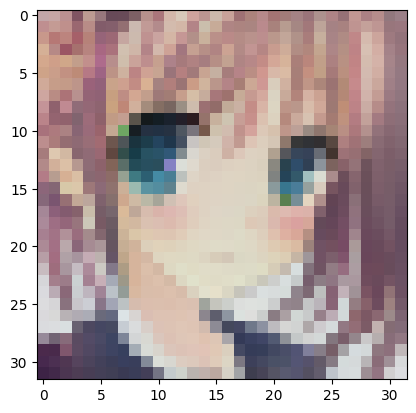

In [22]:
plt.imshow(y2.to(torch.uint8).permute(1, 2, 0))

In [23]:
p,q,r = [],[],[]

## 00

In [24]:
a,b,c,d = [],[],[],[]
for i in range(80):
    x1 = torchaudio.load(wav_paths.collect_files()[898+i])[0]
    x2 = torchaudio.load(wav_paths.collect_files()[1298+i])[0]
    x1_mc, x1_f0, x1_sp, x1_ap = ex_mc(x1)
    x2_mc, x2_f0, x2_sp, x2_ap = ex_mc(x2)
    x_hat2_mc = vae(x1_mc.unsqueeze(0).unsqueeze(0).to(torch.float), y2.unsqueeze(0)).squeeze(0).squeeze(0)
    x_bar2_mc = vqvae(x1_mc.unsqueeze(0).unsqueeze(0).to(torch.float), y2.unsqueeze(0)).squeeze(0).squeeze(0)
    a.append(x1_mc.numpy())
    b.append(x2_mc.numpy())
    c.append(x_hat2_mc.detach().numpy())
    d.append(x_bar2_mc.detach().numpy())

In [25]:
p.append(calc_melcd(a, b))
q.append(calc_melcd(c, b))
r.append(calc_melcd(d, b))

In [26]:
len(a)

80

In [27]:
p,q,r

([(9.357663092768835, 0.39453525203876316)],
 [(7.602459522065596, 0.27982300735365384)],
 [(7.482437317609178, 0.2925278522816525)])

## 01

In [28]:
a,b,c,d = [],[],[],[]
for i in range(80,100):
    x1 = torchaudio.load(wav_paths.collect_files()[898+i])[0]
    x2 = torchaudio.load(wav_paths.collect_files()[1298+i])[0]
    x1_mc, x1_f0, x1_sp, x1_ap = ex_mc(x1)
    x2_mc, x2_f0, x2_sp, x2_ap = ex_mc(x2)
    x_hat2_mc = vae(x1_mc.unsqueeze(0).unsqueeze(0).to(torch.float), y2.unsqueeze(0)).squeeze(0).squeeze(0)
    x_bar2_mc = vqvae(x1_mc.unsqueeze(0).unsqueeze(0).to(torch.float), y2.unsqueeze(0)).squeeze(0).squeeze(0)
    a.append(x1_mc.numpy())
    b.append(x2_mc.numpy())
    c.append(x_hat2_mc.detach().numpy())
    d.append(x_bar2_mc.detach().numpy())

In [29]:
len(a)

20

In [30]:
p.append(calc_melcd(a, b))
q.append(calc_melcd(c, b))
r.append(calc_melcd(d, b))

In [31]:
p,q,r

([(9.357663092768835, 0.39453525203876316),
  (9.296772738864915, 0.3298349591896075)],
 [(7.602459522065596, 0.27982300735365384),
  (7.5249455110008565, 0.2628631745122564)],
 [(7.482437317609178, 0.2925278522816525),
  (7.406047673356349, 0.2524621822647819)])

## 10

In [32]:
y1 = idatasets[0]
y2 = idatasets[1]

/work/kenya/splitternet/data/dataset.py:173: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.random.choice(self.data[label][index])
/work/kenya/splitternet/data/dataset.py:173: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.random.choice(self.data[label][index])


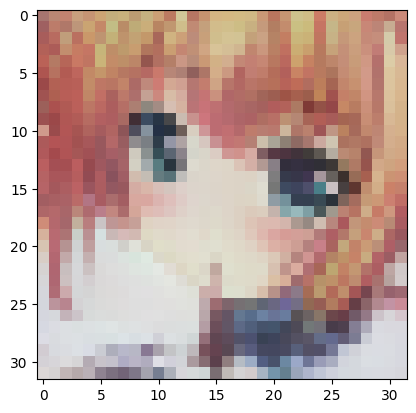

In [33]:
plt.imshow(y2.to(torch.uint8).permute(1, 2, 0))

In [34]:
a,b,c,d = [],[],[],[]
for i in range(80):
    x1 = torchaudio.load(wav_paths.collect_files()[100+i])[0]
    x2 = torchaudio.load(wav_paths.collect_files()[300+i])[0]
    x1_mc, x1_f0, x1_sp, x1_ap = ex_mc(x1)
    x2_mc, x2_f0, x2_sp, x2_ap = ex_mc(x2)
    x_hat2_mc = vae(x1_mc.unsqueeze(0).unsqueeze(0).to(torch.float), y2.unsqueeze(0)).squeeze(0).squeeze(0)
    x_bar2_mc = vqvae(x1_mc.unsqueeze(0).unsqueeze(0).to(torch.float), y2.unsqueeze(0)).squeeze(0).squeeze(0)
    a.append(x1_mc.numpy())
    b.append(x2_mc.numpy())
    c.append(x_hat2_mc.detach().numpy())
    d.append(x_bar2_mc.detach().numpy())

In [35]:
p.append(calc_melcd(a, b))
q.append(calc_melcd(c, b))
r.append(calc_melcd(d, b))

In [36]:
p,q,r

([(9.357663092768835, 0.39453525203876316),
  (9.296772738864915, 0.3298349591896075),
  (8.998302860738951, 0.3325947808168329)],
 [(7.602459522065596, 0.27982300735365384),
  (7.5249455110008565, 0.2628631745122564),
  (7.303840803073041, 0.3539666866597734)],
 [(7.482437317609178, 0.2925278522816525),
  (7.406047673356349, 0.2524621822647819),
  (7.253752038439825, 0.35854402716493783)])

## 11

In [37]:
a,b,c,d = [],[],[],[]
for i in range(80,100):
    x1 = torchaudio.load(wav_paths.collect_files()[100+i])[0]
    x2 = torchaudio.load(wav_paths.collect_files()[300+i])[0]
    x1_mc, x1_f0, x1_sp, x1_ap = ex_mc(x1)
    x2_mc, x2_f0, x2_sp, x2_ap = ex_mc(x2)
    x_hat2_mc = vae(x1_mc.unsqueeze(0).unsqueeze(0).to(torch.float), y2.unsqueeze(0)).squeeze(0).squeeze(0)
    x_bar2_mc = vqvae(x1_mc.unsqueeze(0).unsqueeze(0).to(torch.float), y2.unsqueeze(0)).squeeze(0).squeeze(0)
    a.append(x1_mc.numpy())
    b.append(x2_mc.numpy())
    c.append(x_hat2_mc.detach().numpy())
    d.append(x_bar2_mc.detach().numpy())

In [38]:
p.append(calc_melcd(a, b))
q.append(calc_melcd(c, b))
r.append(calc_melcd(d, b))

In [46]:
p = np.array(p)
q = np.array(q)
r = np.array(r)

In [54]:
p[:, 1]+p[:, 0]

array([9.75219834, 9.6266077 , 9.33089764, 9.06979823])

Text(0, 0.5, 'MelCD[dB]')

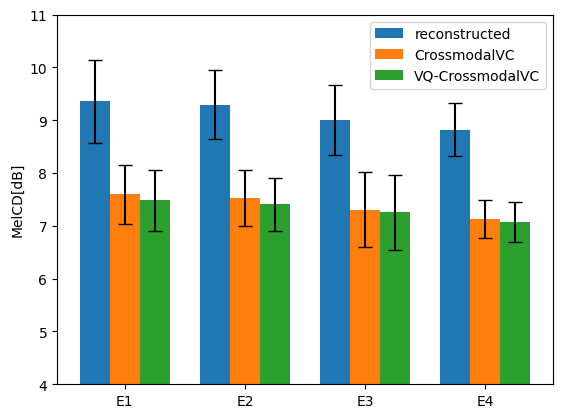

In [62]:
left = np.array([1, 2, 3, 4])
height = np.array([p,q,r])
label = ["E1", "E2", "E3", "E4"]
fig, ax = plt.subplots()
width = 0.25
ax.bar(left-width, p[:,0], yerr=p[:,1]*2, capsize=5, width=width, align="center", label="reconstructed")
ax.bar(left, q[:,0], yerr=q[:,1]*2, capsize=5, tick_label=label, width=width, align="center", label="CrossmodalVC")
ax.bar(left+width, r[:,0], yerr=r[:,1]*2, capsize=5, width=width, align="center", label="VQ-CrossmodalVC")
ax.set_ylim(bottom=4, top=11)
ax.legend()
plt.ylabel('MelCD[dB]')

Text(0, 0.5, 'MCD[dB]')

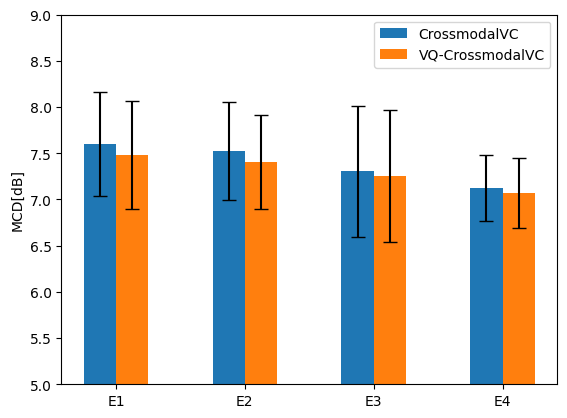

In [74]:
left = np.array([1, 2, 3, 4])
height = np.array([q,r])
label = ["E1", "E2", "E3", "E4"]
fig, ax = plt.subplots()
width = 0.25
ax.bar(left-width/2, q[:,0], yerr=q[:,1]*2, capsize=5, width=width, align="center", label="CrossmodalVC")
ax.bar(left+width/2, r[:,0], yerr=r[:,1]*2, capsize=5, width=width, align="center", label="VQ-CrossmodalVC")
ax.set_xticks(left)
ax.set_xticklabels(label)
ax.set_ylim(bottom=5, top=9)
ax.legend()
ax.set_ylabel('MCD[dB]')